In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 100
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

y_iqr = S_train.get_y_iqr()
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, y_iqr=y_iqr)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True, y_iqr=y_iqr),
      #gp.NumericParameterMutator(all=False, y_iqr=y_iqr)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, X_mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         1341825 function calls (1150955 primitive calls) in 4.283 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.118    0.000    4.272    0.001 corrector.py:48(correct)
     4900    0.073    0.000    2.252    0.000 corrector.py:100(backprop_know)
     4879    0.078    0.000    1.198    0.000 library.py:512(cquery)
     3910    0.037    0.000    0.842    0.000 library.py:556(__local_cquery)
     4862    0.011    0.000    0.766    0.000 library.py:78(query)
     4862    0.456    0.000    0.755    0.000 _kdtree.py:363(query)
13004/4900    0.015    0.000    0.604    0.000 syntax_tree.py:134(pull_know)
9283/3938    0.223    0.000    0.601    0.000 binop.py:185(pull_know)
67367/12667    0.153    0.000    0.580    0.000 binop.py:29(__getitem__)
25906/9758    0.054    0.000    0.535    0.000 syntax_tree.py:139(pull_know_deriv)
18506/7834    0.386    0.000    0.531    0.000 binop.py:255(pull_know_deriv)
     4879 

In [5]:
profiling.print_stats()

         1341825 function calls (1150955 primitive calls) in 4.283 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.118    0.000    4.272    0.001 corrector.py:48(correct)
     4900    0.073    0.000    2.252    0.000 corrector.py:100(backprop_know)
     4879    0.078    0.000    1.198    0.000 library.py:512(cquery)
     3910    0.037    0.000    0.842    0.000 library.py:556(__local_cquery)
     4862    0.011    0.000    0.766    0.000 library.py:78(query)
     4862    0.456    0.000    0.755    0.000 _kdtree.py:363(query)
13004/4900    0.015    0.000    0.604    0.000 syntax_tree.py:134(pull_know)
9283/3938    0.223    0.000    0.601    0.000 binop.py:185(pull_know)
67367/12667    0.153    0.000    0.580    0.000 binop.py:29(__getitem__)
25906/9758    0.054    0.000    0.535    0.000 syntax_tree.py:139(pull_know_deriv)
18506/7834    0.386    0.000    0.531    0.000 binop.py:255(pull_know_deriv)
     4879 

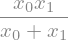

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 1.9102678364638164e-31, 'rmse': 4.3706610901141907e-16, 'r2': 1.0}

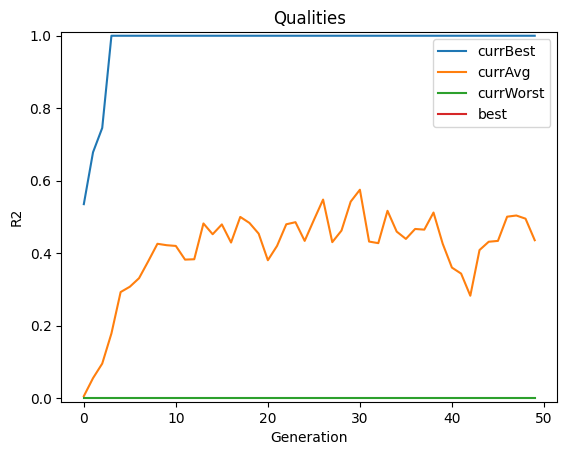

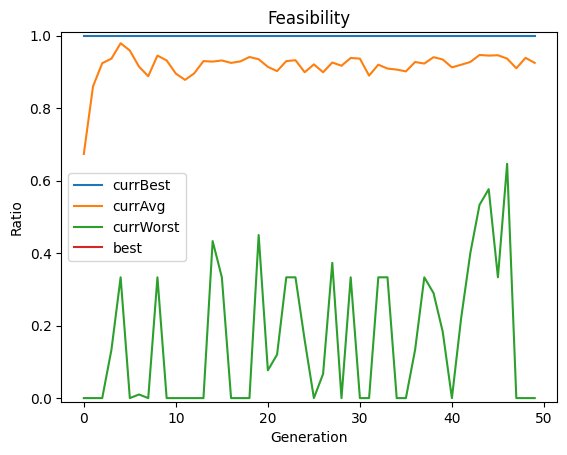

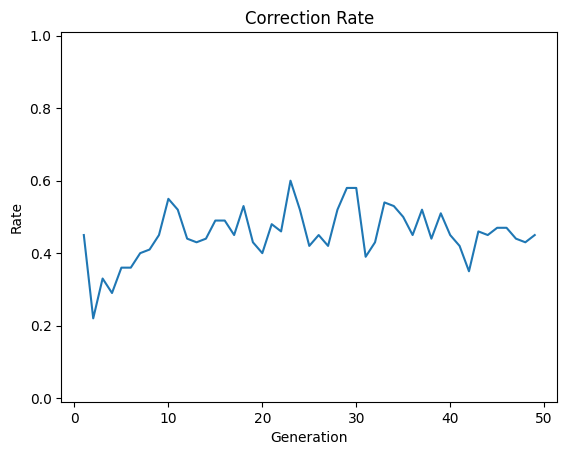

In [8]:
symb_regressor.stats.plot()

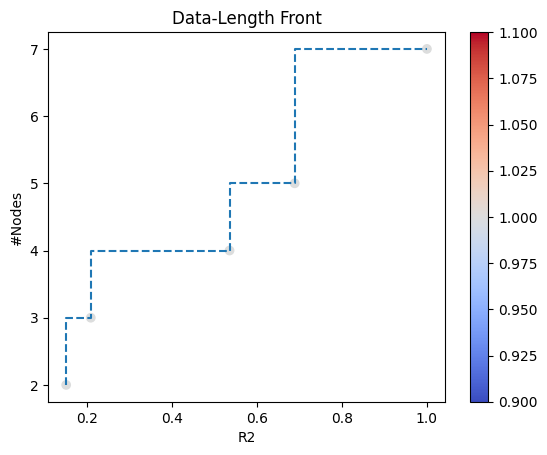

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,sqrt(x1),0,0.135458,0.150509,2,(sqrt),1,inf
1,1,(x1 / ((x1 + x0) / x0)),0,0.650000,1.000000,7,"(+, /)",1,inf
2,2,sqrt((sqrt(x1) * x0)),0,0.516460,0.688613,5,"(sqrt, *)",1,1.147124
3,3,sqrt((x1 + x0)),0,0.428178,0.535223,4,"(+, sqrt)",1,0.965225
4,4,(0.40 * x0),0,0.177191,0.208460,3,(),1,0.852876
5,0,sqrt(x0),1,0.094546,0.105051,2,(sqrt),1,inf
6,1,(x1 / ((x1 + (x0 + -0.00)) / x0)),1,0.550000,1.000000,9,"(+, /)",1,inf
7,2,log(sqrt(exp(sqrt((x1 * x0))))),1,0.622873,0.958266,7,"(log, exp, sqrt, *)",1,0.948235
8,3,sqrt((0.02 + (x1 + x0))),1,0.374450,0.534928,6,"(+, sqrt)",2,0.910872
9,4,sqrt((x1 + x1)),1,0.421305,0.526631,4,"(+, sqrt)",2,0.887119


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)